# [IAPR][iapr]: Project


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Cours/MA2/Image analysis /project_repo/iapr/project

/content/drive/MyDrive/Cours/MA2/Image analysis /project_repo/iapr/project


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Functions

In [4]:
def add_border(im):
    im = im.copy()
    row, col = im.shape[:2]
    bottom = im[row-2:row, 0:col]
    mean = cv2.mean(bottom)[0]

    bordersize = 200
    border = cv2.copyMakeBorder(
        im,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[mean, mean, mean]
    )

    return border

def green_mask(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_green = np.array([30, 70, 70])
    upper_green = np.array([95, 255,255])
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    return mask

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

def crop_rectangle(img, rect, player):
    safety = 50
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    x = int(rect[0][0])
    y = int(rect[0][1])
    width = int(rect[1][0])
    height = int(rect[1][1])

    # Making sure longest side is always height
    if width > height:
        temp = width
        width = height
        height = temp

    #print(f"For player {player}, width is {width} and height is {height}, center x is {x} and center y is {y}")

    w = int(width/2)
    h = int(height/2)

    if player == "1" or player == "3":
        crop_img = img[y-h-safety:y+h+safety, x-w-safety:x+w+safety]
    elif player == "2" or player == "4":
        crop_img = img[y-w-safety:y+w+safety, x-h-safety:x+h+safety]

    # get angle from rotated rectangle
    angle = rect[-1]

    # from https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle

    #print(angle,"deg")

    if player == "1":
        player_img = rotate_image(crop_img, -angle)
    elif player == "2":
        player_img = rotate_image(crop_img, -angle-90)
    elif player == "3":
        player_img = rotate_image(crop_img, -angle-180)
    elif player == "4":
        player_img = rotate_image(crop_img, -angle-270)


    return player_img


def convert_card_to_mnist(card):

    gray = cv2.cvtColor(card, cv2.COLOR_RGB2GRAY)
    # Simple binary threshold
    _, gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    # Find contours
    cnts, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Generate mask
    mask = np.ones(gray.shape)
    mask = cv2.drawContours(mask, cnts, -1, 0, cv2.FILLED)
    # Generate output
    output = card.copy()
    output[mask.astype(np.bool), :] = 0
    cnt = sorted(cnts, key=cv2.contourArea)[-1]
    ## (4) Crop and save it
    x,y,w,h = cv2.boundingRect(cnt)
    dst = card[y:y+h, x:x+w]


    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    # Simple binary threshold
    _, gray = cv2.threshold(gray, 128, 235, cv2.THRESH_BINARY)
    # Find contours
    cnts, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    output = dst.copy()

    if len(cnts) != 0:
        # draw in blue the contours that were founded
        cv2.drawContours(output, cnts, -1, 255, 3)

        # find the second biggest countour (c) by the area
        c = sorted(cnts, key=cv2.contourArea)[-2]
        #print(cv2.contourArea(c))
        x,y,w,h = cv2.boundingRect(c)

        # draw the biggest contour (c) in green
        cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),2)
        dst = dst[y-60:y+h+60, x-60:x+w+60]





    #Getting the bigger side of the image
    s = max(dst.shape[0:2])
    #Creating a dark square with NUMPY
    ads = np.zeros((s,s,3),np.uint8)
    ads.fill(255) # or img[:] = 255
    #Getting the centering position
    ax,ay = (s - dst.shape[1])//2,(s - dst.shape[0])//2
    #Pasting the 'image' in a centering position
    ads[ay:dst.shape[0]+ay,ax:ax+dst.shape[1]] = dst

    row, col = ads.shape[:2]
    bottom = ads[row-2:row, 0:col]
    mean = cv2.mean(bottom)[0]

    bordersize = 50
    border = cv2.copyMakeBorder(
        ads,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )


    #plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    #f, axarr = plt.subplots(1,4)
    #f.tight_layout()

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    gray = cv2.cvtColor(border, cv2.COLOR_BGR2GRAY)
    number = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
    mnist =  cv2.resize(number, dim, interpolation = cv2.INTER_AREA)

    #axarr[0].imshow(output, cmap="gray")
    #axarr[1].imshow(dst, cmap="gray")
    #axarr[2].imshow(border, cmap="gray")
    #axarr[3].imshow(mnist, cmap="gray")

    return mnist

In [5]:
from sklearn.cluster import KMeans
def closest_color(rgb):

    COLORS = (
    (0, 0, 0),
    (237, 28, 36),
    (255, 255, 255))

    r, g, b = rgb
    color_diffs = []
    for color in COLORS:
        cr, cg, cb = color
        color_diff = np.sqrt(abs(r - cr)**2 + abs(g - cg)**2 + abs(b - cb)**2)
        color_diffs.append((color_diff, color))
    return min(color_diffs)[1]

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None

    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image

    def dominantColors(self):

        #read image
        img = self.IMAGE

        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))

        #save image after operations
        self.IMAGE = img

        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)

        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_

        #save labels
        self.LABELS = kmeans.labels_

        #returning after converting to integer from float
        return self.COLORS.astype(int)



def extract_symbol(card):

    gray = cv2.cvtColor(card, cv2.COLOR_RGB2GRAY)
    # Simple binary threshold
    _, gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    # Find contours
    cnts, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Generate mask
    mask = np.ones(gray.shape)
    mask = cv2.drawContours(mask, cnts, -1, 0, cv2.FILLED)
    # Generate output
    output = card.copy()
    output[mask.astype(np.bool), :] = 0
    cnt = sorted(cnts, key=cv2.contourArea)[-1]
    ## (4) Crop and save it
    x,y,w,h = cv2.boundingRect(cnt)
    dst = card[y:y+h, x:x+w]


    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    # Simple binary threshold
    _, gray = cv2.threshold(gray, 128, 235, cv2.THRESH_BINARY)
    # Find contours
    cnts, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    output = dst.copy()
    clean_copy = dst.copy()

    c = None

    for cnt in cnts:
        if cv2.contourArea(cnt) > 1500 and cv2.contourArea(cnt) < 7000:
            c = cnt
    
    if c is None:
        c = cnts[0]


    # draw in blue the contours that were found
    cv2.drawContours(output, c, -1, 255, 3)
    # find the second biggest countour (c) by the area
    #c = sorted(cnts, key=cv2.contourArea)[-2]
    x,y,w,h = cv2.boundingRect(c)

    # draw the biggest contour (c) in green
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),2)
    dst = dst[y-60:y+h+60, x-60:x+w+60]

    symbol_contour = c #sorted(cnts, key=cv2.contourArea)[-4]
    #print('Symbol contour : ', symbol_contour)
    x,y,w,h = cv2.boundingRect(symbol_contour)
    # draw the biggest contour (c) in green
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),2)
    #print(x, y, w, h)
    if (y-1 < 0) | (x-1 < 0):
        return clean_copy
    extracted_symbol = clean_copy[y-1:y+h+1, x-1:x+w+1]

    # if the contour center is on top left or bottom right
    # if the area of bottom left and top right is approximatly the same
    # then it's the right contour to be extracted
    #plt.imshow(e)




    #Getting the bigger side of the image
    s = max(extracted_symbol.shape[0:2])
    #Creating a dark square with NUMPY
    ads = np.zeros((s,s,3),np.uint8)
    ads.fill(255) # or img[:] = 255
    #Getting the centering position
    ax,ay = (s - extracted_symbol.shape[1])//2,(s - extracted_symbol.shape[0])//2
    #Pasting the 'image' in a centering position
    ads[ay:extracted_symbol.shape[0]+ay,ax:ax+extracted_symbol.shape[1]] = extracted_symbol

    row, col = ads.shape[:2]
    bottom = ads[row-2:row, 0:col]
    mean = cv2.mean(bottom)[0]

    bordersize = 50
    border = cv2.copyMakeBorder(
        ads,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )


    #plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    #f, axarr = plt.subplots(1,5)
    #f.tight_layout()

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    #print('extracted symbol: ', extracted_symbol)
    #plt.imshow(extract_symbol)
    #print(len(extracted_symbol))
    #print(extracted_symbol.shape)
    if len(extracted_symbol) == 0:
        print('LENGTH ZEROS!')
        return np.zeros(20, 20)
    gray = cv2.cvtColor(extracted_symbol, cv2.COLOR_BGR2RGB)
    #mnist =  cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)

    #axarr[0].imshow(output, cmap="gray")
    #axarr[1].imshow(dst, cmap="gray")
    #axarr[2].imshow(border, cmap="gray")
    #axarr[3].imshow(mnist, cmap="gray")
   # axarr[4].imshow(gray, cmap="gray")

    return gray

## Preprocessing

In [801]:
games = [[cv2.imread(f'train_games/game{j}/{i}.jpg') for i in range(1, 14)] for j in range(1, 8)]


In [802]:
mnist_cards = []
mnist_shapes = []
dealers_total = []
j = 1

a = 0
#games = [[cv2.imread(f'train_games/game{j}/{i}.jpg') for i in range(1, 14)] for j in range(1, 8)]
for game in games:
    a = a+1
    game_mnist_cards = []
    dealers_game = []
    b = 0
    game_mnist_shapes = []
    for round in game:
        b = b+1
        round = add_border(round)
        print(f"We are in round {b-1} of game {a-1}")
        # convert to RGB
        test_image = round.copy()
        image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

        green_maskino = green_mask(image)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
        dilated_img = cv2.dilate(green_maskino, kernel)

        best_contours = []
        image_for_drawing_contours = np.zeros_like(image)
        contours, hierarchy = cv2.findContours(dilated_img,
            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        boxes = []
        rectangles_mat = []

        for cnt in contours:
            if cv2.contourArea(cnt) > 35000 and cv2.contourArea(cnt) < 1500000:
                best_contours.append(cnt)
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                boxes.append(box)
                rectangles_mat.append(rect)
                cv2.drawContours(image_for_drawing_contours,[box],0,(255,255,255),-1)
        #Get areas of boxes
        boxes_areas = [cv2.contourArea(box) for box in boxes]

        #Find the index of the minimum area box
        #min_index = boxes_areas.index(min(boxes_areas))
        players_boxes = boxes.copy()
        rectangles = rectangles_mat.copy()

        # If the dealer card is detected
        if len(players_boxes) >= 5:
            #Remove the minimum area box for the mask (dealer)

            long_sides = [np.abs(rectangles[i][1][0]/rectangles[i][1][1]-1) for i in range(len(rectangles))]
            min_index = np.argmin(np.array(long_sides))
            
            #print([rectangles[i][1][0]/rectangles[i][1][1] for i in range(len(rectangles))])

            dealer_box  = players_boxes[min_index]
            dealer_rectangle = rectangles[min_index]
            card_boxes = boxes_areas.copy()
            card_boxes.remove(card_boxes[min_index])

            #Remove the same box for the players labeling
            del players_boxes[min_index]
            del rectangles[min_index]



        #Erode mask so that it really only keeps the cards and not surrounding green parts
        kernel = np.ones((80,80),np.uint8)
        eroded_boxes = cv2.erode(image_for_drawing_contours,kernel,iterations = 1)

        players_image = round.copy()
        players_image = cv2.bitwise_and(players_image, eroded_boxes)
        #fig, ax = plt.subplots(figsize=(5, 5))
        #plt.imshow(players_image)
        centers_x = []
        centers_y = []
        dealer_distances = []
        
        #Dealer annotation
        center_x_dealer = np.mean(dealer_box[:,0])
        center_y_dealer = np.mean(dealer_box[:,1])
        center_dealer = np.array([center_x_dealer, center_y_dealer])
        

        for (box,rec) in zip(players_boxes,rectangles):
            center_x = np.mean(box[:,0])
            center_y = np.mean(box[:,1])
            center_card = np.array([center_x, center_y])
            centers_x.append(center_x)
            centers_y.append(center_y)

            # Distance to dealer
            dealer_distance = np.linalg.norm(center_dealer-center_card)
            dealer_distances.append(dealer_distance)

            if 1100<center_x<2700:
                if 3200<center_y<4800:
                    #ax.annotate('Player 1', (center_x, center_y), color = 'red', size = 9, xytext = (center_x+300, center_y))
                    player1_card = crop_rectangle(players_image, rec, "1")
                if 200<center_y<1700:
                    #ax.annotate('Player 3', (center_x, center_y), color = 'red', size = 9, xytext = (center_x+300, center_y))
                    player3_card = crop_rectangle(players_image, rec, "3")
            elif 1700<center_y<3200:
                if 2600<center_x<3656:
                    #ax.annotate('Player 2', (center_x, center_y), color = 'red', size = 9, xytext = (center_x-200, center_y+400))
                    player2_card = crop_rectangle(players_image, rec, "2")
                if 200<center_x<1400:
                    #ax.annotate('Player 4', (center_x, center_y), color = 'red', size = 9, xytext = (center_x-200, center_y+400))
                    player4_card = crop_rectangle(players_image, rec, "4")
        
        if 1000<center_x_dealer<2700:
            if 3200<center_y_dealer<4800:
                dealers_game.append(1)
            if 200<center_y_dealer<1700:
                dealers_game.append(3)
        elif 1700<center_y_dealer<3200:
            if 2600<center_x_dealer<3656:
                dealers_game.append(2)
            if 200<center_x_dealer<1400:
                dealers_game.append(4)

        #dealer_index = dealer_distances.index(min(dealer_distances))
        #print(f"In round {b} and game {a}, the dealer is player number {players_order[dealer_index]}")
        #dealers_game.append(players_order[dealer_index])
        #ax.annotate('Dealer', (center_x_dealer, center_y_dealer), color = 'red', size = 9, xytext = (center_x_dealer-200, center_y_dealer+400))
        #plt.figure()

        #subplot(r,c) provide the no. of rows and columns
        #f, axarr = plt.subplots(1,4)
        #f.tight_layout()

        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        #axarr[0].imshow(player1_card)
        #axarr[1].imshow(player2_card)
        #axarr[2].imshow(player3_card)
        #axarr[3].imshow(player4_card)


        thresh = 160
        dim = (28, 28)
        mnist_player_1 = 255 - convert_card_to_mnist(player1_card)
        mnist_player_2 = 255 - convert_card_to_mnist(player2_card)
        mnist_player_3 = 255 - convert_card_to_mnist(player3_card)
        mnist_player_4 = 255 - convert_card_to_mnist(player4_card)
        
        #_, mnist_player_1 = cv2.threshold(convert_card_to_mnist(player1_card), 100, 255, cv2.THRESH_OTSU)
        #_, mnist_player_2 = cv2.threshold(convert_card_to_mnist(player2_card), 100, 255, cv2.THRESH_OTSU)
        #_, mnist_player_3 = cv2.threshold(convert_card_to_mnist(player3_card), 100, 255, cv2.THRESH_OTSU)
        #_, mnist_player_4 = cv2.threshold(convert_card_to_mnist(player4_card), 100, 255, cv2.THRESH_OTSU)

        #mnist_player_1 = cv2.bitwise_not(mnist_player_1)
        #mnist_player_2 = cv2.bitwise_not(mnist_player_2)
        #mnist_player_3 = cv2.bitwise_not(mnist_player_3)
        #mnist_player_4 = cv2.bitwise_not(mnist_player_4)

        game_mnist_cards.append([mnist_player_1, mnist_player_2, mnist_player_3, mnist_player_4])


        ######### CEDRIC SHAPE DETECTION ###########

        thresh = 160
        dim = (28, 28)

        output_symbols = []
        mnist_player_1 = extract_symbol(player1_card)
        mnist_player_2 = extract_symbol(player2_card)
        mnist_player_3 = extract_symbol(player3_card)
        mnist_player_4 = extract_symbol(player4_card)

        symbol_array = []
        symbol_array.append(mnist_player_1)
        symbol_array.append(mnist_player_2)
        symbol_array.append(mnist_player_3)
        symbol_array.append(mnist_player_4)

        output_colors = []
        grey_symbol_array = []

        clusters = 2
        index = 0

        for symbol in symbol_array:

            #print("Symbol:")

            dc = DominantColors(symbol, clusters)
            colors = dc.dominantColors()

            if closest_color(colors[0]) == (237, 28, 36):
                output_colors.append("RED")
            elif closest_color(colors[1]) == (237, 28, 36):
                output_colors.append("RED")
            elif closest_color(colors[0]) == (0, 0, 0):
                output_colors.append("BLACK")
            elif closest_color(colors[1]) == (0, 0, 0):
                output_colors.append("BLACK")

            # get area and compare heart with diamond
            gray_symboler = cv2.cvtColor(symbol, cv2.COLOR_RGB2GRAY)
            # Simple binary threshold
            _, gray_symboler = cv2.threshold(gray_symboler, 128, 255, cv2.THRESH_BINARY)

            grey_symbol_array.append(gray_symboler)
            # Find contours
            cnts, _ = cv2.findContours(gray_symboler, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            #print(len(cnts))
            if len(cnts) < 2:
                output_symbols.append('H')
            else:
                cnt = sorted(cnts, key=cv2.contourArea)[-2]
                area = cv2.contourArea(cnt)
                perimeter = cv2.arcLength(cnt,True)
                #print(area/perimeter)
                """plt.figure()
                plt.imshow(gray_symboler)"""

                #first, second, third = find_norms(gray_symboler)
                polygon = cv2.approxPolyDP(cnt, 0.01*perimeter, True)
                nb_edges = len(polygon)
                #plt.title(f"{nb_edges}")

                if output_colors[index] == "RED":
                    if nb_edges>8:
                        output_symbols.append("H")
                    else:
                        output_symbols.append("D")
                else:
                    if nb_edges > 15:
                        output_symbols.append("C")
                    else:
                        output_symbols.append("S")
            index = index + 1
        game_mnist_shapes.append(output_symbols)
            ######### CEDRIC SHAPE DETECTION END ###########

        #plt.figure()

        #subplot(r,c) provide the no. of rows and columns
        #f, axarr = plt.subplots(1,4)
        #f.tight_layout()

        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        #axarr[0].imshow(mnist_player_1, cmap="gray")
        #axarr[1].imshow(mnist_player_2, cmap="gray")
        #axarr[2].imshow(mnist_player_3, cmap="gray")
        #axarr[3].imshow(mnist_player_4, cmap="gray")
    dealers_total.append(dealers_game)
    mnist_shapes.append(game_mnist_shapes)
    mnist_cards.append(game_mnist_cards)


We are in round 0 of game 0
We are in round 1 of game 0
We are in round 2 of game 0
We are in round 3 of game 0
We are in round 4 of game 0
We are in round 5 of game 0
We are in round 6 of game 0
We are in round 7 of game 0
We are in round 8 of game 0
We are in round 9 of game 0
We are in round 10 of game 0
We are in round 11 of game 0
We are in round 12 of game 0
We are in round 0 of game 1
We are in round 1 of game 1
We are in round 2 of game 1
We are in round 3 of game 1
We are in round 4 of game 1
We are in round 5 of game 1
We are in round 6 of game 1
We are in round 7 of game 1
We are in round 8 of game 1
We are in round 9 of game 1
We are in round 10 of game 1
We are in round 11 of game 1
We are in round 12 of game 1
We are in round 0 of game 2
We are in round 1 of game 2
We are in round 2 of game 2
We are in round 3 of game 2
We are in round 4 of game 2
We are in round 5 of game 2
We are in round 6 of game 2
We are in round 7 of game 2
We are in round 8 of game 2
We are in roun

## Data augmentation

In [ ]:
all_queens=[]
all_kings=[]
all_jacks=[]

for i in range(1, 8):
    df_q = pd.read_csv(f'train_games/game{i}/game{i}.csv')[['P1', 'P2', 'P3', 'P4']]
    df_q.columns = [0, 1, 2, 3]
    df_q = df_q[ df_q[0].str.startswith('Q') | df_q[1].str.startswith('Q') | 
        df_q[2].str.startswith('Q') | df_q[3].str.startswith('Q')]
    df_q = df_q.apply(lambda x: x.str.startswith('Q'))
    result_q = pd.melt(df_q.reset_index(), id_vars=['index'])
    mask_q = result_q['value'] == True
    result_q = result_q.loc[mask_q, ['index', 'variable']]
    result_q.columns = [0, 1]
    queens = result_q.to_numpy()
    all_queens.append(queens)

    df_j = pd.read_csv(f'train_games/game{i}/game{i}.csv')[['P1', 'P2', 'P3', 'P4']]
    df_j.columns = [0, 1, 2, 3]
    df_j = df_j[ df_j[0].str.startswith('J') | df_j[1].str.startswith('J') | 
        df_j[2].str.startswith('J') | df_j[3].str.startswith('J')]
    df_j = df_j.apply(lambda x: x.str.startswith('J'))
    result_j = pd.melt(df_j.reset_index(), id_vars=['index'])
    mask_j = result_j['value'] == True
    result_j = result_j.loc[mask_j, ['index', 'variable']]
    result_j.columns = [0, 1]
    jacks = result_j.to_numpy()
    all_jacks.append(jacks)

    df_k = pd.read_csv(f'train_games/game{i}/game{i}.csv')[['P1', 'P2', 'P3', 'P4']]
    df_k.columns = [0, 1, 2, 3]
    df_k = df_k[ df_k[0].str.startswith('K') | df_k[1].str.startswith('K') | 
        df_k[2].str.startswith('K') | df_k[3].str.startswith('K')]
    df_k = df_k.apply(lambda x: x.str.startswith('K'))
    result_k = pd.melt(df_k.reset_index(), id_vars=['index'])
    mask_k = result_k['value'] == True
    result_k = result_k.loc[mask_k, ['index', 'variable']]
    result_k.columns = [0, 1]
    kings = result_k.to_numpy()
    all_kings.append(kings)


In [ ]:
queens_mnist = []
jacks_mnist = []
kings_mnist = []


for i in range(0,len(all_queens)):
    for queen in all_queens[i]:
        queen_mnist = mnist_cards[i][queen[0]][queen[1]]
        queens_mnist.append(queen_mnist)

for i in range(0,len(all_jacks)):
    for jack in all_jacks[i]:
        jack_mnist = mnist_cards[i][jack[0]][jack[1]]
        jacks_mnist.append(jack_mnist)
        
for i in range(0,len(all_kings)):
    for king in all_kings[i]:
        king_mnist = mnist_cards[i][king[0]][king[1]]
        kings_mnist.append(king_mnist)

del queens_mnist[18]

del jacks_mnist[25]
del jacks_mnist[15]



## Dataset augmentation for figures

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
import os

image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join('data')
#data_part2_folder = os.path.join(data_base_path, data_folder, 'data')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
import imgaug
import imgaug.augmenters as iaa

seq_figures = iaa.Sequential([
	iaa.Affine(rotate=(-0.01, 0.01))])

seq_digits = iaa.Sequential([
	iaa.Affine(scale = (0.5, 0.6))])

In [ ]:
# 180 rotate half of figures
"""for i in range(0,len(kings_mnist)//2):
    jacks_mnist[i] = cv2.rotate(jacks_mnist[i], cv2.ROTATE_180)
    queens_mnist[i] = cv2.rotate(queens_mnist[i], cv2.ROTATE_180)
    kings_mnist[i] = cv2.rotate(kings_mnist[i], cv2.ROTATE_180)"""
    


augmented_digits = np.array(train_images) # seq_digits(images=train_images)

augmented_jacks = np.array(seq_figures(images=jacks_mnist))
jacks_dataset = np.array(jacks_mnist) #np.concatenate((np.array(jacks_mnist), augmented_jacks), axis=0)
jacks_labels = np.array([10]*len(jacks_mnist)) #np.array([10]*(len(augmented_jacks)+len(jacks_mnist)))

augmented_queens = np.array(seq_figures(images=queens_mnist))
queens_dataset = np.array(queens_mnist) # np.concatenate((np.array(queens_mnist), augmented_queens), axis=0)
queens_labels = np.array([11]*len(queens_mnist)) # np.array([11]*(len(augmented_queens)+len(queens_mnist)))

augmented_kings = np.array(seq_figures(images=kings_mnist))
kings_dataset = np.array(kings_mnist) # np.concatenate((np.array(kings_mnist), augmented_kings), axis=0)
kings_labels = np.array([12]*len(kings_mnist)) # np.array([12]*(len(augmented_kings)+len(kings_mnist)))



In [ ]:
full_training_data = np.concatenate((augmented_digits, 
                                       jacks_dataset, 
                                       queens_dataset, 
                                       kings_dataset))
full_training_labels = np.concatenate((train_labels, 
                                       jacks_labels,                            
                                       queens_labels,
                                       kings_labels))


In [ ]:
import random

c = list(zip(full_training_data, full_training_labels))

random.shuffle(c)

full_training_data, full_training_labels = zip(*c)

In [ ]:
from torchvision import datasets, transforms
Transform = transforms.ToTensor()
train_set = [(Transform(image), label) for image, label in zip(full_training_data, full_training_labels)]
test_set = [(Transform(image), label) for image, label in zip(full_training_data[54164:], full_training_labels[54164:])]

## Classification

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 13.8702, Accuracy: 355/5918 (6%)

Train Epoch: 1 [0/60082 (0%)]	Loss: 23.627064
Train Epoch: 1 [6400/60082 (11%)]	Loss: 1.390625
Train Epoch: 1 [12800/60082 (21%)]	Loss: 1.476609
Train Epoch: 1 [19200/60082 (32%)]	Loss: 0.657371
Train Epoch: 1 [25600/60082 (43%)]	Loss: 0.751485
Train Epoch: 1 [32000/60082 (53%)]	Loss: 0.439767
Train Epoch: 1 [38400/60082 (64%)]	Loss: 0.856064
Train Epoch: 1 [44800/60082 (75%)]	Loss: 0.785894
Train Epoch: 1 [51200/60082 (85%)]	Loss: 0.439487
Train Epoch: 1 [57600/60082 (96%)]	Loss: 0.461620

Test set: Avg. loss: 0.1395, Accuracy: 5674/5918 (96%)

Train Epoch: 2 [0/60082 (0%)]	Loss: 0.578820
Train Epoch: 2 [6400/60082 (11%)]	Loss: 0.303063
Train Epoch: 2 [12800/60082 (21%)]	Loss: 0.543778
Train Epoch: 2 [19200/60082 (32%)]	Loss: 0.327685
Train Epoch: 2 [25600/60082 (43%)]	Loss: 0.262201
Train Epoch: 2 [32000/60082 (53%)]	Loss: 0.370845
Train Epoch: 2 [38400/60082 (64%)]	Loss: 0.545265
Train Epoch: 2 [44800/60082 (75%)]	Loss: 0.38961

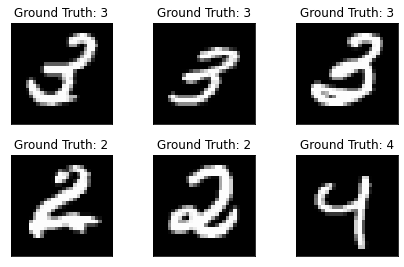

In [ ]:
import torch
import torchvision

n_epochs = 15
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.9
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size_train)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 13)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
network = network.cuda()

optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# Transfer everything to GPU


def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = network(data)
    #loss = F.nll_loss(output, target, weight=classes_weights)
    loss = F.nll_loss(output, target)

    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

In [ ]:
torch.save(network, 'absolute_best_model.pkl')

## Queens kings and jacks

---
## 0. Introduction

An anonymous researcher that we will name Lann Yecun is convinced that the MNIST dataset still has great potential. He decides to create a playing card game based on MNIST digits and different figures. The game uses a standard 52 card deck which is composed of four French suits/colours: clubs (&#9827;), diamonds (&#9830;), hearts (&#9829;) and spades (&#9824;). Each suit includes 10 digit cards (from 0 to 9) and 3 figures (Jack-J, Queen-Q, and King-K). Here is an example of the 13 spade cards with their name.


<img src="media/example_cards.png">


We can find the same arrangement of cards for the clubs, diamonds, and hearts. 


## 1. Rules


### 1.1 Standard

The rules are based on the simple battle card game. The goal of the game is to win as many points as possible. Each turn, the 4 players play a card in front of them. As displayed in the example below. The rules are the following:

- The cards are ranked in the following order : **0 < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < J < Q < K**.
- The player with the highest-ranked card wins the round and obtains **1 point**. 
- If the highest-ranked card is the same for multiple players we call it a draw and all winners get **1 points**. 
- In this configuration, we **do not** take into account the suits. The game only rely on the card ranks. 
- The game lasts 13 rounds. After the last round, the winner is the player that has the largest number of points. 
- In the example below Player 1 wins the round with his Queen ( 0 < 8 < J < **Q**).

If two or more players have the same number of points they share the victory.

### 1.2 Advanced

The advanced rules take into account the suits. 

- At the beginning of **each round** a random player is designated as the **dealer**. The dealer places a green token with the letter *D* next to him (player 1 in the example below).
- Only the cards that belong to the same suit as the one of the dealer are considered valid. In the example below, only Player 4 is competing with Player 1 as spade was selected by the dealer (e.i., Player 1). Player 2 and 3 are out for this round. Player 1 wins the round and **1 point** with the Queen ( 0&#9824; < **Q&#9824;**).
- There cannot be any draw between the players as they are not any card duplicates.
- We use the same system as the standard method to count the points.


<img src="media/example_round.jpg">


### 1.3 Notes

- The orientation of the card is linked to the position of the player around the table. For instance, to read the card of the 3rd player you will have to rotate it by 180°.
- The **digits** always **face** the players around the table. The figures can have random orientations.
- Player 1 **always** seats south of the table. The players are **always** ordered counter-clockwise as in the example. 
- The dealers can change between the rounds and games.
- Some cards **might** apear multiple times per game.
- Pictures are always taken from rougthly the same altitude.
- The digits from the training set **would not** be the same as the one of the testing set.

---
## 2. Data

You will be given the images of 7 games that were played ([download link](https://drive.google.com/drive/folders/1fEy27wnJsUJPRsEEomzoAtP56s-7HFtk?usp=sharing)). The data are composed of:
   - 7 folder named after the games (game1 to game7).
   - Each game includes 13 ordered images (1st to 13th round).
   - Each game includes a csv file with the ground truth of the game. The first row list the players (P1 to P4) as well as the dealer (D). The following rows represent the rounds (1 to 13). We represent the card played with 2 character as $AB$ where $A \in [0-9, J, Q, K]$ is the rank of the card and $B \in [C, D, H, S]$ is the suit. For example, QS means "(Q)ueen of (S)pade" and 0D means "(0) of (D)iamond". The dealer is represented by the ID of the player (e.g. P1 -> 1).
   
You are free to use external datasets such as the original MNIST train set that you used in lab 3.

---
## 3. Your Tasks

Your task is to ready yourself for the final evaluation. The day of the exam we will give you a new folder with a new game. ! The digits on the cards **differ** from the one of the traning set. When given a new data folder with 13 images your should be able to:

**Task 0**
   - Plot an overlay for each round image that shows your detections and classification. You can for example plot bounding boxes around the cards/dealer token and add a text overlay with the name of the classes.

**Task 1**
   - (a) Predict the **rank** of the card played by each player at each round (Standard rules).
   - (b) Predict the **number of points** of each player according to **Standard** rules
 
**Task 2**
   - (a) Detect which player is the selected **dealer** for each round.
   - (b) Predict the **rank** and the **suit** of the card played by each player at each round (Advanced rules).
   - (c) Predict the **number of points** of each player according to **Advanced** rules

---

**Before the exam (until 03.06.21 at 23h59)**
   - Create a zipped folder named **group_xx.zip** that you uplaod on moodel (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam (04.06.21)**
   - You will be given a **new folder** with 13 images (rounds) and but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **realtime** and to send us your prediction of task 1 and 2 that you obtain with the function **print_results**. 
   - On our side we will compute the perfomance of your classification algorithm. 
   - To evaluate your method we will use the **evaluate_game** function presented below. To understant how the provided functions work please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty the day of the exam**. 

---
### 3.1 Example Final results

Example of output you **should** provide the day of the final exam.

In [837]:
from utils import print_results, evaluate_game
import numpy as np

game_index = 4
mnist_cards_torch = torch.tensor(mnist_cards)

gd_truth = pd.read_csv(f'train_games/game{game_index+1}/game{game_index+1}.csv')[['P1', 'P2', 'P3', 'P4', 'D']]
gd_truth.columns = [1, 2, 3, 4, 'D']
gd_truth.values[:, :4]

network.eval()
game_final_cards = []
for round_cards in mnist_cards_torch[game_index]: # cards is an array with the 4 cards of the round
    round_cards = round_cards.view(4, 1, 28, 28).float().cuda()
    np_predictions = torch.argmax(network(round_cards), axis=1).cpu().numpy()
    game_final_cards.append(np_predictions)
game_cards = []
for i in range(13):
    round_cards = []
    for j in range(4):
        #string = f'{mnist_shapes[0][i][j]}'
        if game_final_cards[i][j] == 10:
            number = 'J'
        elif game_final_cards[i][j] == 11:
            number = 'Q'
        elif game_final_cards[i][j] == 12:
            number = 'K'
        else:
            number = game_final_cards[i][j]
        string = f'{number}'+ f'{mnist_shapes[game_index][i][j]}'
        round_cards.append(string)
    game_cards.append(round_cards)
game_cards
player_dealer = dealers_total[game_index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [838]:
player_dealer = [player_dealer[i]-1 for i in range(len(player_dealer))]

player_nb = np.zeros((13,4))
player_nb_advanced = np.zeros((13,4))
winners_standard = []
winners_advanced = []
s = 0
fict_game = np.array(game_cards)

# For every game
for j in range(fict_game.shape[0]):
    
    # Find the suit of the dealer
    suit = fict_game[j][player_dealer[s]][1]
    
    # For every player
    for i in range(fict_game.shape[1]):
        
        if fict_game[j][i][0] == 'J':
            player_nb[j][i] = 10
            player_nb_advanced[j][i] = 10
        elif fict_game[j][i][0] == 'Q':
            player_nb[j][i] = 11
            player_nb_advanced[j][i] = 11
        elif fict_game[j][i][0] == 'K':
            player_nb[j][i] = 12
            player_nb_advanced[j][i] = 12
        else:
            player_nb[j][i] = fict_game[j][i][0]
            player_nb_advanced[j][i] = fict_game[j][i][0]
        
        if fict_game[j][i][1] != suit:
            player_nb_advanced[j][i] = -1
        else:
            player_nb_advanced[j][i] = player_nb_advanced[j][i]
            
        
    m_standard = max(player_nb[j])
    winner_standard_index = [l for l, k in enumerate(player_nb[j]) if k == m_standard]
    
    m_advanced = max(player_nb_advanced[j])
    winner_advanced_index = [l for l, k in enumerate(player_nb_advanced[j]) if k == m_advanced]
    
    s = s+1
    
    for y in range(len(winner_standard_index)):
        winners_standard.append(winner_standard_index[y])
        
        
    for u in range(len(winner_advanced_index)):
        winners_advanced.append(winner_advanced_index[u])
    
players_points_standard = np.zeros(4)
players_points_advanced = np.zeros(4)

for i in range(0,4):
    players_points_standard[i] = winners_standard.count(i)
    players_points_advanced[i] = winners_advanced.count(i)

print_results(
    rank_colour=np.array(game_cards), 
    dealer=dealers_total[4], 
    pts_standard=players_points_standard,
    pts_advanced=players_points_advanced,
)

The cards played were:
[
['JH', '2S', '9C', '0C'], 
['2D', '3S', '7S', '6H'], 
['8D', '4C', 'JS', 'JD'], 
['4S', '6S', '3C', '5S'], 
['5C', 'KC', '3H', 'KH'], 
['6H', 'QH', '6D', 'QS'], 
['3H', 'KH', '8S', 'KS'], 
['5H', '1C', '5H', 'QC'], 
['KD', '2H', '8H', '0H'], 
['QD', '3D', '4D', '2C'], 
['6S', 'JC', '0S', '8C'], 
['8D', '7H', '0D', '1H'], 
['1D', '6C', '0H', '1S'], 
]
Players designated as dealer: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Players points (standard): [4. 6. 2. 5.]
Players points (advanced): [0. 3. 2. 8.]


In [840]:
evaluate_game(np.array(game_cards), gd_truth.values[:, :4], mode_advanced=True)

0.9423076923076923

---
### 3.2 Example Accuracy

Example of code you can use to validate the performance of your model. Be careful the day of the exam you will not have access to the ground truth of the predictions.

In [ ]:
from utils import evaluate_game
import pandas as pd
#! You will need pandas libary to run the example. Please install the package using pip or conda commands !

# Load ground truth from game 1
cgt = pd.read_csv('train_games/game1/game1.csv', index_col=0)
cgt_rank = cgt[['P1', 'P2', 'P3', 'P4']].values

# Compute accuracy of prediction
acc_standard = evaluate_game(pred_rank, cgt_rank, mode_advanced=False)
acc_advanced = evaluate_game(pred_rank, cgt_rank, mode_advanced=True)
print("Your model accuracy is: Standard={:.3f}, Advanced={:.3f}".format(acc_standard, acc_advanced))

Your model accuracy is: Standard=0.077, Advanced=0.019


# Cells to run for presentation

We are in round 0 of game 0
We are in round 1 of game 0
We are in round 2 of game 0
We are in round 3 of game 0
We are in round 4 of game 0
We are in round 5 of game 0
We are in round 6 of game 0
We are in round 7 of game 0
We are in round 8 of game 0
We are in round 9 of game 0
We are in round 10 of game 0
We are in round 11 of game 0
We are in round 12 of game 0


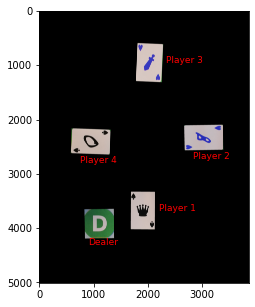

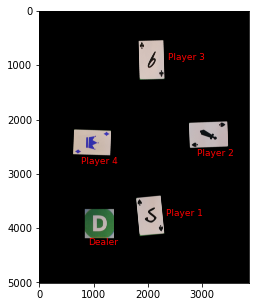

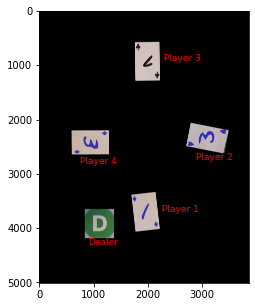

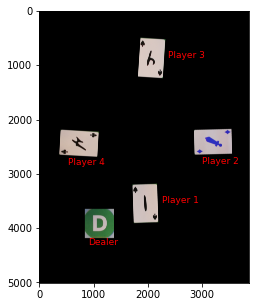

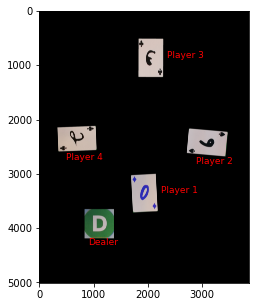

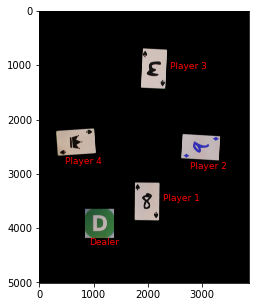

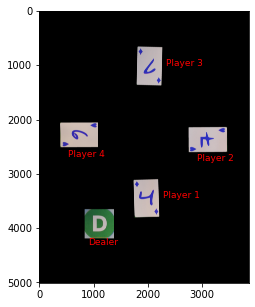

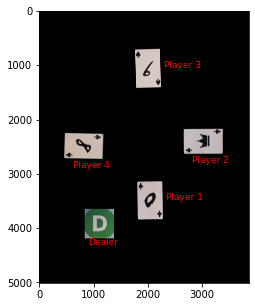

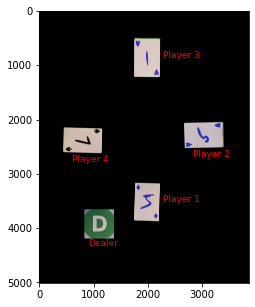

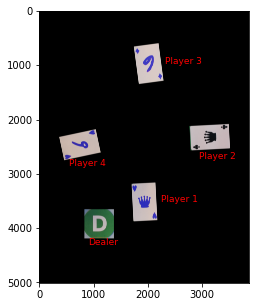

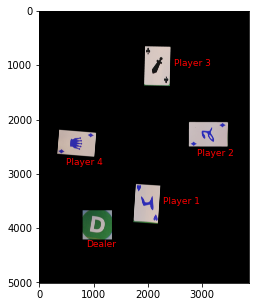

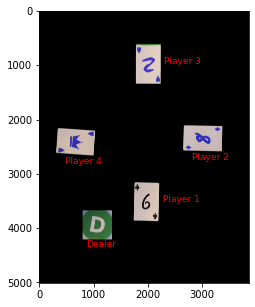

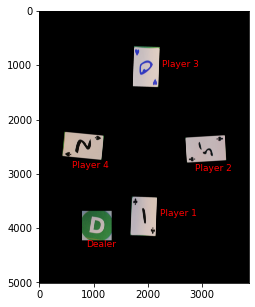

In [11]:
from utils import print_results, evaluate_game
import numpy as np
import torch
import cv2

games = [[cv2.imread(f'train_games/game{j}/{i}.jpg') for i in range(1, 14)] for j in range(1, 2)]

# Loop through all images
mnist_cards = []
mnist_shapes = []
dealers_total = []
j = 1

a = 0
#games = [[cv2.imread(f'train_games/game{j}/{i}.jpg') for i in range(1, 14)] for j in range(1, 8)]
for game in games:
    a = a+1
    game_mnist_cards = []
    dealers_game = []
    b = 0
    game_mnist_shapes = []
    for round in game:
        b = b+1
        round = add_border(round)
        print(f"We are in round {b-1} of game {a-1}")
        # convert to RGB
        test_image = round.copy()
        image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

        green_maskino = green_mask(image)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
        dilated_img = cv2.dilate(green_maskino, kernel)

        best_contours = []
        image_for_drawing_contours = np.zeros_like(image)
        contours, hierarchy = cv2.findContours(dilated_img,
            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        boxes = []
        rectangles_mat = []

        for cnt in contours:
            if cv2.contourArea(cnt) > 35000 and cv2.contourArea(cnt) < 1500000:
                best_contours.append(cnt)
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                boxes.append(box)
                rectangles_mat.append(rect)
                cv2.drawContours(image_for_drawing_contours,[box],0,(255,255,255),-1)
        #Get areas of boxes
        boxes_areas = [cv2.contourArea(box) for box in boxes]

        #Find the index of the minimum area box
        #min_index = boxes_areas.index(min(boxes_areas))
        players_boxes = boxes.copy()
        rectangles = rectangles_mat.copy()

        # If the dealer card is detected
        if len(players_boxes) >= 5:
            #Remove the minimum area box for the mask (dealer)

            long_sides = [np.abs(rectangles[i][1][0]/rectangles[i][1][1]-1) for i in range(len(rectangles))]
            min_index = np.argmin(np.array(long_sides))
            
            #print([rectangles[i][1][0]/rectangles[i][1][1] for i in range(len(rectangles))])

            dealer_box  = players_boxes[min_index]
            dealer_rectangle = rectangles[min_index]
            card_boxes = boxes_areas.copy()
            card_boxes.remove(card_boxes[min_index])

            #Remove the same box for the players labeling
            del players_boxes[min_index]
            del rectangles[min_index]



        #Erode mask so that it really only keeps the cards and not surrounding green parts
        kernel = np.ones((80,80),np.uint8)
        eroded_boxes = cv2.erode(image_for_drawing_contours,kernel,iterations = 1)

        players_image = round.copy()
        players_image = cv2.bitwise_and(players_image, eroded_boxes)
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.imshow(players_image)
        centers_x = []
        centers_y = []
        dealer_distances = []
        
        #Dealer annotation
        center_x_dealer = np.mean(dealer_box[:,0])
        center_y_dealer = np.mean(dealer_box[:,1])
        center_dealer = np.array([center_x_dealer, center_y_dealer])
        

        for (box,rec) in zip(players_boxes,rectangles):
            center_x = np.mean(box[:,0])
            center_y = np.mean(box[:,1])
            center_card = np.array([center_x, center_y])
            centers_x.append(center_x)
            centers_y.append(center_y)

            # Distance to dealer
            dealer_distance = np.linalg.norm(center_dealer-center_card)
            dealer_distances.append(dealer_distance)

            if 1100<center_x<2700:
                if 3200<center_y<4800:
                    ax.annotate('Player 1', (center_x, center_y), color = 'red', size = 9, xytext = (center_x+300, center_y))
                    player1_card = crop_rectangle(players_image, rec, "1")
                if 200<center_y<1700:
                    ax.annotate('Player 3', (center_x, center_y), color = 'red', size = 9, xytext = (center_x+300, center_y))
                    player3_card = crop_rectangle(players_image, rec, "3")
            elif 1700<center_y<3200:
                if 2600<center_x<3656:
                    ax.annotate('Player 2', (center_x, center_y), color = 'red', size = 9, xytext = (center_x-200, center_y+400))
                    player2_card = crop_rectangle(players_image, rec, "2")
                if 200<center_x<1400:
                    ax.annotate('Player 4', (center_x, center_y), color = 'red', size = 9, xytext = (center_x-200, center_y+400))
                    player4_card = crop_rectangle(players_image, rec, "4")
        
        if 1000<center_x_dealer<2700:
            if 3200<center_y_dealer<4800:
                dealers_game.append(1)
            if 200<center_y_dealer<1700:
                dealers_game.append(3)
        elif 1700<center_y_dealer<3200:
            if 2600<center_x_dealer<3656:
                dealers_game.append(2)
            if 200<center_x_dealer<1400:
                dealers_game.append(4)

        #dealer_index = dealer_distances.index(min(dealer_distances))
        #print(f"In round {b} and game {a}, the dealer is player number {players_order[dealer_index]}")
        #dealers_game.append(players_order[dealer_index])
        ax.annotate('Dealer', (center_x_dealer, center_y_dealer), color = 'red', size = 9, xytext = (center_x_dealer-200, center_y_dealer+400))
        #plt.figure()

        #subplot(r,c) provide the no. of rows and columns
        #f, axarr = plt.subplots(1,4)
        #f.tight_layout()

        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        #axarr[0].imshow(player1_card)
        #axarr[1].imshow(player2_card)
        #axarr[2].imshow(player3_card)
        #axarr[3].imshow(player4_card)


        thresh = 160
        dim = (28, 28)
        mnist_player_1 = 255 - convert_card_to_mnist(player1_card)
        mnist_player_2 = 255 - convert_card_to_mnist(player2_card)
        mnist_player_3 = 255 - convert_card_to_mnist(player3_card)
        mnist_player_4 = 255 - convert_card_to_mnist(player4_card)
        
        #_, mnist_player_1 = cv2.threshold(convert_card_to_mnist(player1_card), 100, 255, cv2.THRESH_OTSU)
        #_, mnist_player_2 = cv2.threshold(convert_card_to_mnist(player2_card), 100, 255, cv2.THRESH_OTSU)
        #_, mnist_player_3 = cv2.threshold(convert_card_to_mnist(player3_card), 100, 255, cv2.THRESH_OTSU)
        #_, mnist_player_4 = cv2.threshold(convert_card_to_mnist(player4_card), 100, 255, cv2.THRESH_OTSU)

        #mnist_player_1 = cv2.bitwise_not(mnist_player_1)
        #mnist_player_2 = cv2.bitwise_not(mnist_player_2)
        #mnist_player_3 = cv2.bitwise_not(mnist_player_3)
        #mnist_player_4 = cv2.bitwise_not(mnist_player_4)

        game_mnist_cards.append([mnist_player_1, mnist_player_2, mnist_player_3, mnist_player_4])


        ######### CEDRIC SHAPE DETECTION ###########

        thresh = 160
        dim = (28, 28)

        output_symbols = []
        mnist_player_1 = extract_symbol(player1_card)
        mnist_player_2 = extract_symbol(player2_card)
        mnist_player_3 = extract_symbol(player3_card)
        mnist_player_4 = extract_symbol(player4_card)

        symbol_array = []
        symbol_array.append(mnist_player_1)
        symbol_array.append(mnist_player_2)
        symbol_array.append(mnist_player_3)
        symbol_array.append(mnist_player_4)

        output_colors = []
        grey_symbol_array = []

        clusters = 2
        index = 0

        for symbol in symbol_array:

            #print("Symbol:")

            dc = DominantColors(symbol, clusters)
            colors = dc.dominantColors()

            if closest_color(colors[0]) == (237, 28, 36):
                output_colors.append("RED")
            elif closest_color(colors[1]) == (237, 28, 36):
                output_colors.append("RED")
            elif closest_color(colors[0]) == (0, 0, 0):
                output_colors.append("BLACK")
            elif closest_color(colors[1]) == (0, 0, 0):
                output_colors.append("BLACK")

            # get area and compare heart with diamond
            gray_symboler = cv2.cvtColor(symbol, cv2.COLOR_RGB2GRAY)
            # Simple binary threshold
            _, gray_symboler = cv2.threshold(gray_symboler, 128, 255, cv2.THRESH_BINARY)

            grey_symbol_array.append(gray_symboler)
            # Find contours
            cnts, _ = cv2.findContours(gray_symboler, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            #print(len(cnts))
            if len(cnts) < 2:
                output_symbols.append('H')
            else:
                cnt = sorted(cnts, key=cv2.contourArea)[-2]
                area = cv2.contourArea(cnt)
                perimeter = cv2.arcLength(cnt,True)
                #print(area/perimeter)
                """plt.figure()
                plt.imshow(gray_symboler)"""

                #first, second, third = find_norms(gray_symboler)
                polygon = cv2.approxPolyDP(cnt, 0.01*perimeter, True)
                nb_edges = len(polygon)
                #plt.title(f"{nb_edges}")

                if output_colors[index] == "RED":
                    if nb_edges>8:
                        output_symbols.append("H")
                    else:
                        output_symbols.append("D")
                else:
                    if nb_edges > 15:
                        output_symbols.append("C")
                    else:
                        output_symbols.append("S")
            index = index + 1
        game_mnist_shapes.append(output_symbols)
            ######### CEDRIC SHAPE DETECTION END ###########

        #plt.figure()

        #subplot(r,c) provide the no. of rows and columns
        #f, axarr = plt.subplots(1,4)
        #f.tight_layout()

        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        #axarr[0].imshow(mnist_player_1, cmap="gray")
        #axarr[1].imshow(mnist_player_2, cmap="gray")
        #axarr[2].imshow(mnist_player_3, cmap="gray")
        #axarr[3].imshow(mnist_player_4, cmap="gray")
    dealers_total.append(dealers_game)
    mnist_shapes.append(game_mnist_shapes)
    mnist_cards.append(game_mnist_cards)



In [9]:
# Load weights and test on exam data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 13)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = torch.load('absolute_best_model.pkl')


In [13]:
model.eval()

game_index=0
mnist_cards_torch = torch.tensor(mnist_cards)

game_final_cards = []
for round_cards in mnist_cards_torch[game_index]: # cards is an array with the 4 cards of the round
    round_cards = round_cards.view(4, 1, 28, 28).float().cuda()
    np_predictions = torch.argmax(model(round_cards), axis=1).cpu().numpy()
    game_final_cards.append(np_predictions)
game_cards = []
for i in range(13):
    round_cards = []
    for j in range(4):
        if game_final_cards[i][j] == 10:
            number = 'J'
        elif game_final_cards[i][j] == 11:
            number = 'Q'
        elif game_final_cards[i][j] == 12:
            number = 'K'
        else:
            number = game_final_cards[i][j]
        string = f'{number}'+ f'{mnist_shapes[game_index][i][j]}'
        round_cards.append(string)
    game_cards.append(round_cards)
game_cards
player_dealer = dealers_total[game_index]

player_dealer = [player_dealer[i]-1 for i in range(len(player_dealer))]

player_nb = np.zeros((13,4))
player_nb_advanced = np.zeros((13,4))
winners_standard = []
winners_advanced = []
s = 0
fict_game = np.array(game_cards)

# For every game
for j in range(fict_game.shape[0]):
    
    # Find the suit of the dealer
    suit = fict_game[j][player_dealer[s]][1]
    
    # For every player
    for i in range(fict_game.shape[1]):
        
        if fict_game[j][i][0] == 'J':
            player_nb[j][i] = 10
            player_nb_advanced[j][i] = 10
        elif fict_game[j][i][0] == 'Q':
            player_nb[j][i] = 11
            player_nb_advanced[j][i] = 11
        elif fict_game[j][i][0] == 'K':
            player_nb[j][i] = 12
            player_nb_advanced[j][i] = 12
        else:
            player_nb[j][i] = fict_game[j][i][0]
            player_nb_advanced[j][i] = fict_game[j][i][0]
        
        if fict_game[j][i][1] != suit:
            player_nb_advanced[j][i] = -1
        else:
            player_nb_advanced[j][i] = player_nb_advanced[j][i]
            
        
    m_standard = max(player_nb[j])
    winner_standard_index = [l for l, k in enumerate(player_nb[j]) if k == m_standard]
    
    m_advanced = max(player_nb_advanced[j])
    winner_advanced_index = [l for l, k in enumerate(player_nb_advanced[j]) if k == m_advanced]
    
    s = s+1
    
    for y in range(len(winner_standard_index)):
        winners_standard.append(winner_standard_index[y])
        
        
    for u in range(len(winner_advanced_index)):
        winners_advanced.append(winner_advanced_index[u])
    
players_points_standard = np.zeros(4)
players_points_advanced = np.zeros(4)

for i in range(0,4):
    players_points_standard[i] = winners_standard.count(i)
    players_points_advanced[i] = winners_advanced.count(i)
game_cards = np.array(game_cards)
print_results(
    rank_colour=game_cards, 
    dealer=dealers_total[game_index], 
    pts_standard=players_points_standard,
    pts_advanced=players_points_advanced,
)

#evaluate_game(game_cards, gd_truth.values[:, :4], mode_advanced=True)

The cards played were:
[
['QS', '8H', 'JH', '0S'], 
['5S', 'JS', '9C', 'KD'], 
['1D', '3H', '7C', '3D'], 
['1S', 'JD', '4S', '4C'], 
['0D', '6S', '3C', '2C'], 
['8S', '8D', '3S', 'KS'], 
['4D', '7H', '7D', '6H'], 
['9C', 'KC', '8S', '8C'], 
['5D', '5H', '1H', '7S'], 
['QH', 'QC', '6D', '9H'], 
['4H', '2D', 'JC', 'QD'], 
['6C', '8D', '2H', 'KH'], 
['1C', '5C', '0H', '2S'], 
]
Players designated as dealer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Players points (standard): [2. 6. 2. 5.]
Players points (advanced): [6. 3. 2. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
